# **Batch Normalization Test**



*   Paper link : http://static.googleusercontent.com/media/research.google.com/ko//pubs/archive/43442.pdf


In [ ]:
# import packages
import torch
import torch.nn as nn

# Convolutional Layers

In [ ]:
def conv1x1(input_channel: int, output_channel: int, stride: int=1, bias=False):
  """
  input_channel : Number of channels in the input image
  output_channel : Number of channels in the output, produced by convolution
  stride : Stride of the convolution
  """

  return nn.Conv2d(input_channel, output_channel, kernel_size=1, 
                   stride=stride, bias=bias)

def conv3x3(input_channel: int, output_channel: int, stride: int=1, groups: int=1, 
            dilation: int=1, bias: bool=False):
  """
  input_channel : Number of channels in the input image
  output_channel : Number of channels in the output, produced by convolution
  stride : Stride of the convolution
  groups : Number of blocked connections from input channels to output channels
  dilation : Spacing between kernel elements
  bias : bias usage(bool)
  """

  return nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=stride, 
                   padding=dilation, groups=groups, bias=bias, dilation=dilation)

# Block

In [ ]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, outplanes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None, BN=False):
    """
    inplanes : Input channel size
    outplanes : output channel size
    BN : usage of BatchNormalization
    """

    super(BasicBlock, self).__init__()

    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError()
    if dilation > 1:
      raise NotImplementedError()

    self.BN = BN

    self.conv1 = conv3x3(inplanes, outplanes, stride)

    if BN:
      self.bn1 = norm_layer(outplanes)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = conv3x3(outplanes, outplanes)

    if BN:
      self.bn2 = norm_layer(outplanes)
    
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    if self.BN:
      out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    if self.BN:
      out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [ ]:
class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, outplanes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None, BN=False):
    """
    inplanes : Input channel size
    outplanes : output channel size
    BN : usage of BatchNormalization
    """

    super(BottleNeck, self).__init__()

    if norm_layer is None:
      norm_layer = nn.BatchNorm2d

    width = int(outplanes * (base_width / 64.)) * groups # for wide ResNet

    self.conv1 = conv1x1(inplanes, width)
    if BN:
      self.bn1 = norm_layer(width)

    self.conv2 = conv3x3(width, width, stride, groups, dilation)
    if BN:
      self.bn2 = norm_layer(width)
    
    self.conv3 =  conv1x1(width, outplanes * self.expansion)
    if BN:
      self.bn3 = norm_layer(outplanes * self.expansion)
    self.relu = nn.ReLU(inplace=True)

    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    if self.BN:
      out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    if self.BN:
      out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    if self.BN:
      out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample

    out += identity
    out = self. relu(out)

    return out

# ResNet

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
               groups=1, width_per_group=64, replace_stride_with_dilation=None,
               norm_layer=None, BN=False):
    super(ResNet, self).__init__()
    self.BN = BN

    if norm_layer is None and BN:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.inplanes = 64
    self.dilation = 1

    if replace_stride_with_dilation is None:
      replace_stride_with_dilation = [False, False, False]

    if len(replace_stride_with_dilation) != 3:
      raise ValueError()

    self.groups = groups
    self.base_width = width_per_group

    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                           bias=False)
    if BN:
      self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                   dilate=replace_stride_with_dilation[0])
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                   dilate=replace_stride_with_dilation[1])
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                   dilate=replace_stride_with_dilation[2])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_ (m.weight, 1)
        nn.init.constant_(m.bias, 0)

    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, BottleNeck):
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)

  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
      """
      block : type of block
      planes : input shape
      blocks : size of layer
      """

      norm_layer = self._norm_layer
      downsample = None
      previous_dilation = self.dilation
      if dilate:
        self.dilation *= stride
        stride = 1

      if stride != 1 or self.inplanes != planes * block.expansion:
        if self.BN:
          downsample = nn.Sequential(
              conv1x1(self.inplanes, planes * block.expansion, stride),
              norm_layer(planes * block.expansion),
          )
        else:
          downsample = nn.Sequential(
              conv1x1(self.inplanes, planes * block.expansion, stride),
          )

      layers = []

      layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                          self.base_width, previous_dilation, norm_layer, BN=self.BN))
      self.inplanes = planes * block.expansion

      for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes, groups=self.groups,
                            base_width=self.base_width, dilation=self.dilation,
                            norm_layer=norm_layer, BN=self.BN))
      
      return nn.Sequential(*layers)

  def _forward_impl(self, x):
    x = self.conv1(x)
    if self.BN:
      x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

  def forward(self, x):
    return self._forward_impl(x)

In [ ]:
def resnet18(BN):
  return ResNet(BasicBlock, [2, 2, 2, 2], BN=BN)

In [ ]:
import torchvision
import torchvision.transforms as transforms

train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test = transforms.Compose([
    transforms.ToTensor(),
])

train_data = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=train)
test_data = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=train)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
criterion = nn.CrossEntropyLoss()

def train(net, optimizer, epoch, step):
  net.train()

  correct = 0
  total = 0
  steps = []
  losses = []

  for _, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    _, pred = outputs.max(1)
    correct += pred.eq(targets).sum().item()
    total += targets.size(0)

    steps.append(step)
    losses.append(loss.item())
    step += 1

  return correct / total, steps, losses

def test(net, optimizer, epoch):
  net.eval()

  correct =  0
  total = 0
  loss = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = net(inputs)
    loss += criterion(outputs, targets).item()

    _, pred = outputs.max(1)
    correct += pred.eq(targets).sum().item()
    total += targets.size(0)

  return correct / total, loss

In [ ]:
net = resnet18(False).cuda()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total Params : {total_params}")

Total Params : 11679912


In [ ]:
train_accs_f = []
steps_f = []
train_losses_f = []
test_accs_f = []
test_losses_f = []

epochs = 20

for epoch in range(epochs):
  print(f"Epoch : {epoch}")
  train_acc, step, train_loss = train(net, optimizer, epoch, len(steps_f))
  train_accs_f.append(train_acc)
  steps_f.extend(step)
  train_losses_f.append(train_loss)
  print(f"Train acc : {train_acc * 100:.2f} / Train loss : {sum(train_loss)}")
  print()
  test_acc, test_loss = test(net, optimizer, epoch)
  test_accs_f.append(test_acc)
  test_losses_f.append(test_loss)
  print(f"Test acc : {test_acc * 100:.2f} / Test loss : {test_loss}")
  print('#############')

Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train acc : 18.16 / Train loss : 997.3649997711182

Test acc : 30.57 / Test loss : 188.62242722511292
#############
Epoch : 1
Train acc : 34.96 / Train loss : 693.8918780088425

Test acc : 40.52 / Test loss : 164.01683616638184
#############
Epoch : 2
Train acc : 41.66 / Train loss : 624.8182390928268

Test acc : 45.49 / Test loss : 149.44862639904022
#############
Epoch : 3
Train acc : 46.51 / Train loss : 578.8843486309052

Test acc : 47.65 / Test loss : 144.59503138065338
#############
Epoch : 4
Train acc : 49.45 / Train loss : 549.0295584201813

Test acc : 50.92 / Test loss : 137.75416326522827
#############
Epoch : 5
Train acc : 51.76 / Train loss : 524.4927536249161

Test acc : 49.90 / Test loss : 140.80575168132782
#############
Epoch : 6
Train acc : 54.26 / Train loss : 503.4815580844879

Test acc : 51.83 / Test loss : 135.9232747554779
#############
Epoch : 7
Train acc : 56.06 / Train loss : 485.29700672626495

Test acc : 56.75 / Test loss : 122.6410648226738
#############
Epo

In [ ]:
net = resnet18(True).cuda()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total Params : {total_params}")

Total Params : 11689512


In [ ]:
train_accs = []
steps = []
train_losses = []
test_accs = []
test_losses = []

epochs = 20

for epoch in range(epochs):
  print(f"Epoch : {epoch}")
  train_acc, step, train_loss = train(net, optimizer, epoch, len(steps))
  train_accs.append(train_acc)
  steps.extend(step)
  train_losses.append(train_loss)
  print(f"Train acc : {train_acc * 100:.2f} / Train loss : {sum(train_loss)}")
  print()
  test_acc, test_loss = test(net, optimizer, epoch)
  test_accs.append(test_acc)
  test_losses.append(test_loss)
  print(f"Test acc : {test_acc * 100:.2f} / Test loss : {test_loss}")
  print('#############')

Epoch : 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train acc : 39.02 / Train loss : 677.2238240242004

Test acc : 44.85 / Test loss : 152.93899309635162
#############
Epoch : 1
Train acc : 51.75 / Train loss : 524.1692472696304

Test acc : 40.53 / Test loss : 195.60416185855865
#############
Epoch : 2
Train acc : 58.18 / Train loss : 460.1442031264305

Test acc : 46.10 / Test loss : 167.4566113948822
#############
Epoch : 3
Train acc : 62.56 / Train loss : 411.9053282737732

Test acc : 59.68 / Test loss : 115.6594752073288
#############
Epoch : 4
Train acc : 65.76 / Train loss : 379.81599873304367

Test acc : 64.54 / Test loss : 102.07466548681259
#############
Epoch : 5
Train acc : 67.46 / Train loss : 358.0446130633354

Test acc : 63.90 / Test loss : 104.80995815992355
#############
Epoch : 6
Train acc : 69.54 / Train loss : 337.33546471595764

Test acc : 64.12 / Test loss : 102.01376700401306
#############
Epoch : 7
Train acc : 71.09 / Train loss : 321.31992185115814

Test acc : 67.28 / Test loss : 95.22476863861084
#############
Ep

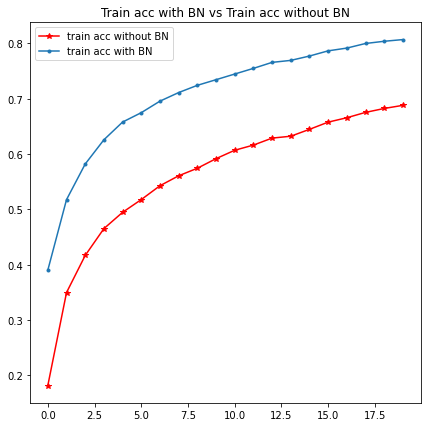

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
plt.plot([x for x in range(epochs)], train_accs_f, 'r*-', label='train acc without BN')
plt.plot([x for x in range(epochs)], train_accs, '.-', label='train acc with BN')
plt.title("Train acc with BN vs Train acc without BN")
plt.legend()

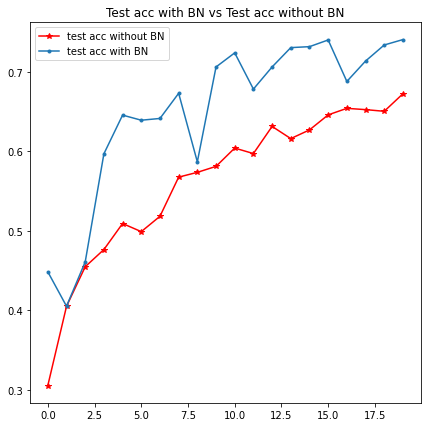

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.plot([x for x in range(epochs)], test_accs_f, 'r*-', label='test acc without BN')
plt.plot([x for x in range(epochs)], test_accs, '.-', label='test acc with BN')
plt.title("Test acc with BN vs Test acc without BN")
plt.legend()

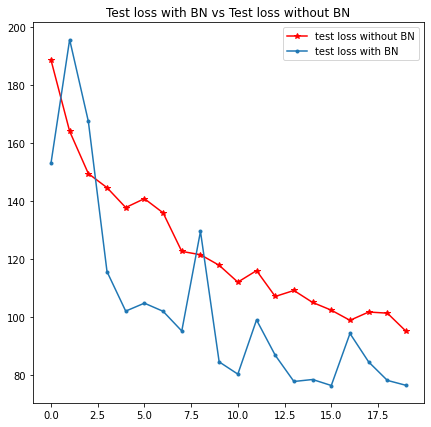

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.plot([x for x in range(epochs)], test_losses_f, 'r*-', label='test loss without BN')
plt.plot([x for x in range(epochs)], test_losses, '.-', label='test loss with BN')
plt.title("Test loss with BN vs Test loss without BN")
plt.legend()